In [8]:
import matplotlib.pyplot as plt
def draw_scale_bar(ax, n_ums=1, scale=1, color='white', position='lower right', **kwargs):
    '''
    Draw a scale bar on the image.
    :param ax: axis object
    :param n_ums: number of micrometers the scale bar should represent
    :param scale: number of pixels to micrometers
    :param color: color of the scale bar
    :param position: position of the scale bar
        Options: 'lower right', 'lower left', 'upper right', 'upper left'
    :param kwargs: additional arguments to be passed to plt.text
    
    :return: axis object
    '''
    
    bottom, top = ax.get_ylim()
    left, right = ax.get_xlim()
    width = right - left
    height = top - bottom
    
    if position == 'lower right':
        x = right - 0.1 * width
        y = bottom + 0.1 * height
        ha = 'right'
        va = 'bottom'
    elif position == 'lower left':
        x = left + 0.1 * width
        y = bottom + 0.1 * height
        ha = 'left'
        va = 'bottom'
    elif position == 'upper right':
        x = right - 0.1 * width
        y = top - 0.1 * height
        ha = 'right'
        va = 'top'
    elif position == 'upper left':
        x = left + 0.1 * width
        y = top - 0.1 * height
        ha = 'left'
        va = 'top'
    else:
        raise ValueError('Invalid position')
    
    x = int(x)
    y = int(y)
    # set default font size
    kwargs['fontsize'] = kwargs.get('fontsize', 12)
    font_size = kwargs['fontsize']
    n_pixels = int(n_ums * scale)
    ax.plot([x, x + n_pixels], [y, y], color=color, lw=2)
    ax.text(x + n_pixels + font_size, y - 5 * font_size, f'{n_ums} μm', ha=ha, va=va, color=color, **kwargs)
    return ax
    

Image size: 1440 x 1080 pixels


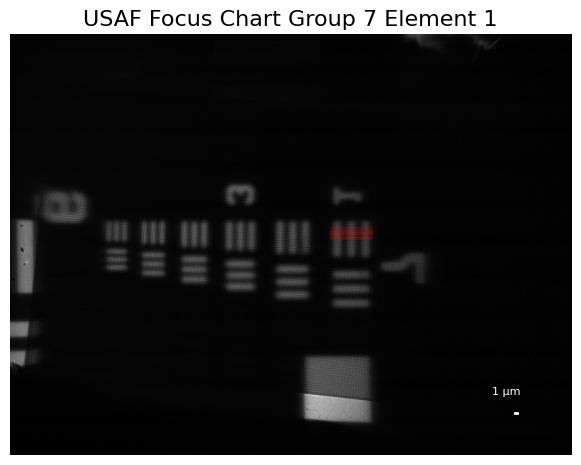

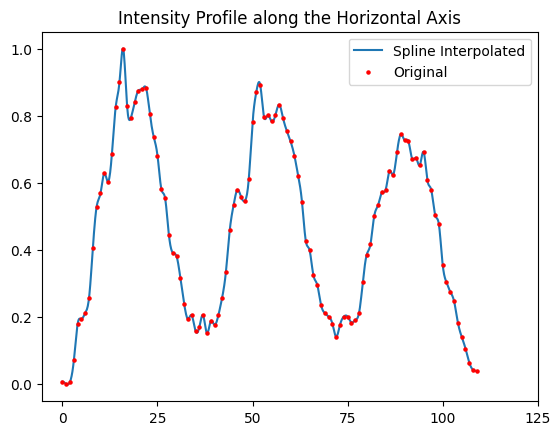

Mean resolution: 3.68 um
Field of view: 191.67 x 255.56 um


In [13]:
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from hyperscope import config

# Load the image
# im = Image.open(r"D:\CZI_scope\code\data\imgs_and_plts\usaf_gr7_el1_2024-07-24T13-23-52.886.bmp").convert('L')  # convert to grayscale
im = Image.open(config.RAW_DATA_DIR / "calibration" / "USAF_EL7_20x_2025-01-10T15-57-56.001.bmp").convert('L')  # convert to grayscale
width, height = im.size
print(f'Image size: {width} x {height} pixels')
im = np.array(im)
magnification = 19.44
pitch = 3.45  # um


# Calculate the intensity profile along the horizontal axis
starting_line = (930, 525, 820, 525)
lines = [starting_line]
spacing = 3  # pixels
for i in range(1, 10):
    y = starting_line[1] - (i * spacing)
    lines.append((starting_line[0], y, starting_line[2], y))  # 10 lines


plt.imshow(im, cmap='gray')
plt.tight_layout()
plt.axis('off')

# Add a 1um scale bar
ax = plt.gca()
draw_scale_bar(ax, n_ums=1, scale=magnification/pitch, color='white', position='lower right', fontsize=8)

# Plot the lines
for line in lines:
    l, = plt.plot([line[0], line[2]], [line[1], line[3]], 'r')
    l.set_linewidth(0.2)
plt.title('USAF Focus Chart Group 7 Element 1', fontsize=16)
plt.show()

# Calculate the intensity profile along the lines
scans = []
for line in lines:
    x1, y1, x2, y2 = line
    if y1 == y2:
        # Horizontal line
        line_scan = im[y1, min(x1, x2):max(x1, x2)]
    else:
        # If lines are neither strictly horizontal nor vertical, handle as needed
        line_scan = im[min(y1, y2):max(y1, y2), min(x1, x2):max(x1, x2)]
    scans.append(line_scan)

# Compute the mean intensity profile
intensity = np.mean(scans, axis=0)
intensity = (intensity - intensity.min()) / (intensity.max() - intensity.min())  # Normalize

# Interpolate the intensity profile as spline
x = np.arange(len(intensity))
f = interp1d(x, intensity, kind='cubic')
x_new = np.linspace(0, len(intensity) - 1, int(1e3))
intensity_interp = f(x_new)

# Plot the intensity profile
plt.figure()
plt.plot(x_new, intensity_interp, label='Spline Interpolated')  # Plot the interpolated intensity profile
dot_size = 5  # Adjust this value to change the dot size
plt.scatter(x, intensity, color='red', s=dot_size, zorder=99, label='Original')
plt.title('Intensity Profile along the Horizontal Axis')
plt.xticks(np.arange(0, 150, 25), )
plt.legend()
plt.show()

# Calculate the derivative of the interpolated intensity profile
derivative = np.gradient(intensity_interp)

# Find the peaks and valleys in the derivative
peaks, _ = find_peaks(derivative)
valleys, _ = find_peaks(-derivative)

# Select the three highest peaks
if len(peaks) >= 3:
    peaks = peaks[np.argsort(derivative[peaks])[-3:]]
else:
    raise ValueError("Not enough peaks found in the intensity profile derivative.")

# Find corresponding valleys for each peak
valley_indices = []
for peak in peaks:
    valley_range = valleys[(valleys > peak) & (valleys < len(derivative))]
    if len(valley_range) > 0:
        valley_indices.append(valley_range[np.argmin(derivative[valley_range])])

# Calculate the distances between the peak and valley pairs
if len(valley_indices) < 3:
    raise ValueError("Not enough valleys found for the detected peaks.")
valley_indices = np.array(valley_indices)
distances = np.abs(x_new[peaks] - x_new[valley_indices])

# Calculate the resolution
resolution = pitch * distances / magnification
mean_resolution = resolution.mean()
print(f'Mean resolution: {mean_resolution:.2f} um')

# Calculate the FOV
fov = (pitch*im.shape[0] / magnification, pitch * im.shape[1] / magnification)
print(f'Field of view: {fov[0]:.2f} x {fov[1]:.2f} um')

Image size: 1440 x 1080 pixels


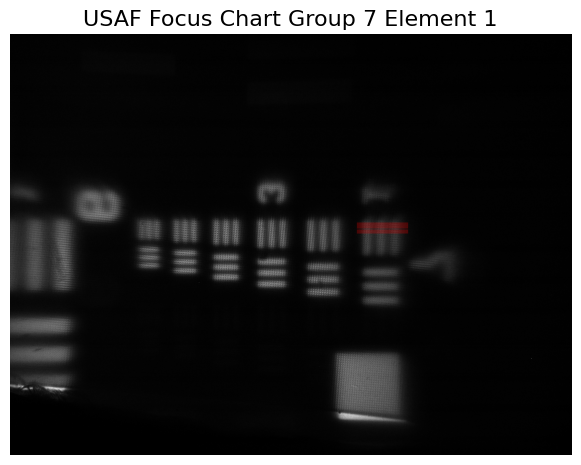

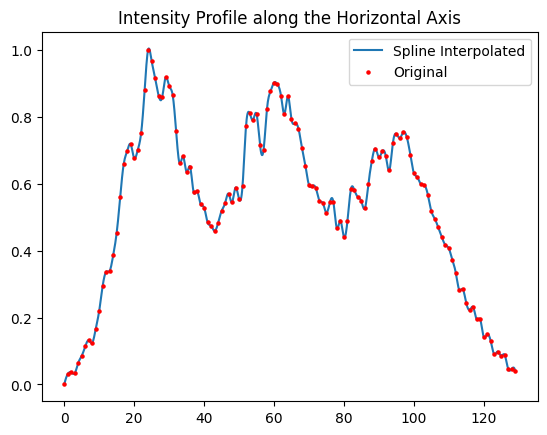

In [7]:
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from hyperscope import config

# Load the image
im = Image.open(config.RAW_DATA_DIR / "calibration" / "USAF_EL7_2025-01-08T12-44-07.998.bmp").convert('L')  # convert to grayscale
width, height = im.size
print(f'Image size: {width} x {height} pixels')
im = np.array(im)
pitch = 3.45  # um

# Calculate the intensity profile along the horizontal axis
starting_line = (1020, 510, 890, 510)
lines = [starting_line]
spacing = 3  # pixels
for i in range(1, 10):
    y = starting_line[1] - (i * spacing)
    lines.append((starting_line[0], y, starting_line[2], y))  # 10 lines

plt.imshow(im, cmap='gray')
plt.tight_layout()
#plt.gca().invert_yaxis()
plt.axis('off')

# Plot the lines
for line in lines:
    l, = plt.plot([line[0], line[2]], [line[1], line[3]], 'r')
    l.set_linewidth(0.2)
plt.title('USAF Focus Chart Group 7 Element 1', fontsize=16)
plt.show()

# Calculate the intensity profile along the lines
scans = []
for line in lines:
    x1, y1, x2, y2 = line
    if y1 == y2:
        # Horizontal line
        line_scan = im[y1, min(x1, x2):max(x1, x2)]
    else:
        # If lines are neither strictly horizontal nor vertical, handle as needed
        line_scan = im[min(y1, y2):max(y1, y2), min(x1, x2):max(x1, x2)]
    scans.append(line_scan)

# Compute the mean intensity profile
intensity = np.mean(scans, axis=0)
intensity = (intensity - intensity.min()) / (intensity.max() - intensity.min())  # Normalize

# Interpolate the intensity profile as spline
x = np.arange(len(intensity))
f = interp1d(x, intensity, kind='cubic')
x_new = np.linspace(0, len(intensity) - 1, int(1e3))
intensity_interp = f(x_new)

# Plot the intensity profile
plt.figure()
plt.plot(x_new, intensity_interp, label='Spline Interpolated')  # Plot the interpolated intensity profile
dot_size = 5  # Adjust this value to change the dot size
plt.scatter(x, intensity, color='red', s=dot_size, zorder=99, label='Original')
plt.title('Intensity Profile along the Horizontal Axis')
plt.legend()
plt.show()

# # Identify the peaks in the intensity profile
# peaks, _ = find_peaks(intensity_interp, distance=100)  # Adjust the distance parameter as needed

# # Calculate the FWHM for each peak
# fwhms = []
# half_max = 0.5  # Half maximum value for normalized intensity

# for peak in peaks:
#     # Find the points where the intensity crosses the half maximum value
#     left_half = np.where(np.diff(np.sign(intensity_interp[:peak] - half_max)))[0]
#     right_half = np.where(np.diff(np.sign(intensity_interp[peak:] - half_max)))[0] + peak

#     if len(left_half) > 0 and len(right_half) > 0:
#         left_idx = left_half[-1]
#         right_idx = right_half[0]
#         fwhm = x_new[right_idx] - x_new[left_idx]
#         fwhms.append(fwhm)
#         # Plot the FWHM on the intensity profile
#         plt.plot([x_new[left_idx], x_new[right_idx]], [intensity_interp[left_idx], intensity_interp[right_idx]], 'go-')

# # Calculate magnification using the known physical width of the peak
# known_width_um = 3.91  # Known width of the peak in micrometers
# average_fwhm_pixels = np.mean(fwhms)
# magnification_calculated = pitch * average_fwhm_pixels / known_width_um
# print(f'Calculated magnification: {magnification_calculated:.2f}')

# # Calculate the resolution
# resolution = pitch * np.array(fwhms) / magnification_calculated
# mean_resolution = resolution.mean()
# print(f'Mean resolution: {mean_resolution:.2f} um')

# # Plot the intensity profile with peaks and FWHM
# plt.figure()
# plt.plot(x_new, intensity_interp, label='Intensity Profile')
# plt.plot(x_new[peaks], intensity_interp[peaks], 'ro', label='Peaks')
# for peak, fwhm in zip(peaks, fwhms):
#     left_half = np.where(np.diff(np.sign(intensity_interp[:peak] - half_max)))[0]
#     right_half = np.where(np.diff(np.sign(intensity_interp[peak:] - half_max)))[0] + peak
#     left_idx = left_half[-1]
#     right_idx = right_half[0]
#     plt.plot([x_new[left_idx], x_new[right_idx]], [intensity_interp[left_idx], intensity_interp[right_idx]], 'go-')
# plt.axhline(half_max, color='r', linestyle='--', label='Half Maximum')
# plt.title('Intensity Profile with FWHM')
# plt.legend()
# plt.show()

# print(f'FWHM values (in pixels): {fwhms}')


In [17]:
cross_points

array([], dtype=int64)